# Modeling

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.15)
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.10f}'.format
plt.rcParams['figure.figsize'] = (8, 4)

In [2]:
#LOAD LOANSTATS
directory = '../../data/'
ls = pd.read_hdf(directory + 'ls_CLEAN.h5', 'ls_CLEAN')
ls.sort_index(axis=1, inplace=True)

## 1. Preprocessing

### 1A. Train-Test Split

Before we begin modeling, we set aside a test set that we will use later to evaluate the predictive quality of our investment strategy. We do this in a stratified fashion ensuring that the outcome classes (fully paid loans and not fully paid loans) are equally represented in the train and test sets. For the splitting algorithm, we use `sklearn`'s `train_test_split` function. This function creates random train and test subsets of the dataset. The flag `stratify` ensures that both classes are equally represented in each set. 

In [3]:
from sklearn.model_selection import train_test_split
ls_train, ls_test = train_test_split(ls, test_size=0.2, stratify=ls['OUT_Class'], random_state=1)

### 1B. Standard Scaling

The models used in the next sections assume that the features are on similar scales. To achieve this, we transform the numeric variables to a standard scale with mean 0 and standard deviation 1 using sklearn's `StandardScaler` function.

In [4]:
#IDENTIFY THE OUTCOME, DUMMY AND NUMERIC VARIABLES
var_list = set(ls.columns)
outcome_var_list = set(out_var for out_var in var_list if "OUT_" in out_var)
dummy_var_list = set(dummy for dummy in var_list if "D_" in dummy)
numeric_var_list = var_list - outcome_var_list - dummy_var_list

In [5]:
#STANDARD SCALER
scaler = StandardScaler()

In [6]:
#SCALE THE TRAINING SETS (fit_transform)
train_vars_scaled = pd.DataFrame(scaler.fit_transform(ls_train[list(numeric_var_list)]),
                                 index=ls_train.index, 
                                 columns=ls_train[list(numeric_var_list)].columns)
feature_train = pd.concat([train_vars_scaled, ls_train[list(dummy_var_list)]], axis=1).sort_index(axis=1)

In [7]:
#STANDARDIZE THE TEST SET (transform)
test_vars_scaled = pd.DataFrame(scaler.transform(ls_test[list(numeric_var_list)]),
                                index=ls_test.index, 
                                columns=ls_test[list(numeric_var_list)].columns)
feature_test = pd.concat([test_vars_scaled, ls_test[list(dummy_var_list)]], axis=1).sort_index(axis=1)

In [8]:
#SET TARGET VARIABLES
outcome_train = ls_train[sorted(outcome_var_list)]
OUT_Class_train = outcome_train.iloc[:,0]
OUT_Principle_Repaid_Percentage_train = outcome_train.iloc[:,1]
OUT_Monthly_Rate_Of_Return_train = outcome_train.iloc[:,2]

outcome_test = ls_test[sorted(outcome_var_list)]
OUT_Class_test = pd.DataFrame(outcome_test.iloc[:,0])
OUT_Principle_Repaid_Percentage_test = outcome_test.iloc[:,1]
OUT_Monthly_Rate_Of_Return_test = outcome_test.iloc[:,2]

### 1C. Model Evaluation Functions

In [9]:
def model_scoring(model, feature, target, modeltype='C', cv=5):
    """Displays model evaluation for regression and classification modeling"""
    scoring = ['accuracy', 'precision', 'recall']
    if modeltype=='R': # regression
        scoring = ['neg_mean_squared_error', 'r2']
    for score in scoring:
        cv_score = cross_val_score(model, feature, target, scoring=score, cv=cv).mean()
        print('Cross-validation {}: {:.4}'.format(score, cv_score))

In [10]:
def display_confusion_matrix(target, target_predicted):
    """Displays confusion matrix for classification models"""
    fig, ax = plt.subplots(figsize=(8,4))
    matrix = pd.DataFrame(confusion_matrix(target, target_predicted),
                      index=['Fully Repaid', 'Not Fully Repaid'],
                      columns=['Fully Repaid', 'Not Fully Repaid'])
    sns.heatmap(matrix, annot=True, fmt='g', cbar=None, cmap='Blues')
    plt.title('Confusion Matrix'), plt.ylabel('True Class'), plt.xlabel('Predicted Class')
    ax.set_xticklabels(['Charged Off', 'Fully Repaid'], va='center')
    ax.set_yticklabels(['Charged Off', 'Fully Repaid'], va='center')
    plt.tight_layout()
    plt.show()

In [11]:
def display_ROC_curve(target, target_probabilities):
    """Displays the ROC curve for classification models"""
    fig, ax = plt.subplots(figsize=(10,4))
    true_pr, false_pr, threshold = roc_curve(target, target_probabilities)

    ax.plot(false_pr, true_pr, label='ROC')
    ax.plot([0,1], ls='--',label='random')
    ax.plot([0,0],[1,0], c='.7', ), plt.plot([1,1], c='.7', label='perfect')
    ax.set_title('Reciever Operating Characterisic')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    plt.legend()
    plt.show()

## 2. Baseline Models

It is insightful to create some very simple models that we can use as a baseline to compare against our actual model. sklearn's `DummyClassifier` and `DummyRegressor` allow us to concretely state the the benefits of usings a machine learning approach.

### 2A. Baseline Classification

A basic measure of a classifier's performance is how much it improves on random guessing. Using sklearn's `dummyclassifer` with flag `strategy='uniform'` generates predictions uniformly at random between the training set's two classes.

In [12]:
#DUMMY CLASSIFIER OF 'OUT_Class' 
dummy_classifier = DummyClassifier(strategy='stratified', random_state=1)
dummy_classifier.fit(feature_train, OUT_Class_train)
model_scoring(dummy_classifier, feature_train, OUT_Class_train)

Cross-validation accuracy: 0.7653
Cross-validation precision: 0.8643
Cross-validation recall: 0.8642


### 2B. Baseline Regression

A basic measure of a regressor's performance is how much better it is than a very simple model that makes constant predictions. Using sklearn's `DummyRegressor` with the flag `strategy='mean'` we get baseline predictions of the mean value in the training set.

In [13]:
#DUMMY REGRESSOR OF 'OUT_Principle_Repaid_Percentage' 
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(feature_train, OUT_Principle_Repaid_Percentage_train)
model_scoring(dummy_regressor, feature_train, OUT_Principle_Repaid_Percentage_train, modeltype='R')

Cross-validation neg_mean_squared_error: -0.00223
Cross-validation r2: -1.209e-05


In [14]:
#DUMMY REGRESSOR OF 'OUT_Monthly_Rate_Of_Return' 
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(feature_train, OUT_Monthly_Rate_Of_Return_train)
model_scoring(dummy_regressor, feature_train, OUT_Monthly_Rate_Of_Return_train, modeltype='R')

Cross-validation neg_mean_squared_error: -0.04668
Cross-validation r2: -1.986e-05


## 2. Binary Classifier

This model is a logistic regression on the outcome variable `OUT_class` which is the binary classification for loans are either fully repaid (1) or charged off (0). The flag `class_weight='balanced'` ensures that both classes are equally represented in each set. 

In [17]:
#LOGISTIC REGRESSION
classifier = LogisticRegression(solver='lbfgs', max_iter=10000, class_weight='balanced', random_state=0)
classifier.fit(feature_train, OUT_Class_train)
model_scoring(classifier, feature_train, OUT_Class_train, modeltype='C')

Cross-validation accuracy: 0.6314
Cross-validation precision: 0.9168
Cross-validation recall: 0.6309


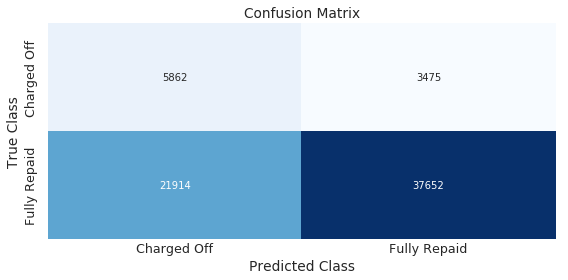

In [18]:
#CONFUSION MATRIX
display_confusion_matrix(OUT_Class_test, classifier.predict(feature_test))

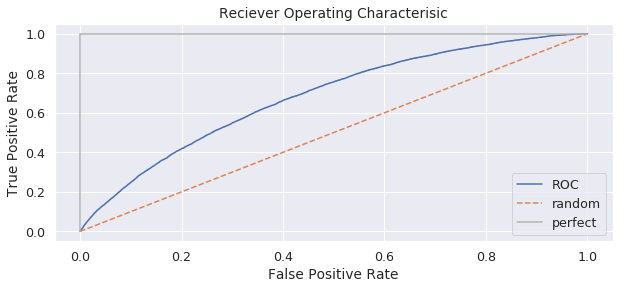

In [19]:
#ROC CURVE
display_ROC_curve(OUT_Class_test, classifier.predict_proba(feature_test)[:,0])

## 3. Linear Regression

## 4. Trees and Forest

## 5. K-Nearest Neighbors

In [ ]:
#target_train_predicted = classifier.predict(feature_train)
#target_train_probabilities = classifier.predict_proba(feature_train)[:,0]
#target_test_predicted = classifier.predict(feature_test)
#target_test_probabilities = classifier.predict_proba(feature_test)[:,0]

In [ ]:
##ACCURACY
#train_set_accuracy = dummy_classifier.score(feature_train, target_train)
#print('Train Set Accuracy: {:.4}'.format(train_set_accuracy))

##ACCURACY
#test_set_accuracy = dummy_classifier.score(feature_test, target_test)
#print('Test Set Accuracy: {:.4}'.format(test_set_accuracy))